In [97]:
import os

import numpy as np
import astropy.units as u

import matplotlib.pyplot as plt

import lsst.daf.persistence
import lsst.meas.astrom
import lsst.afw.table

In [6]:
# switch this for use on lsst-dev
datadir = '/Users/parejkoj/lsst/jointcal/jointcal/tests/.test/JointcalTestCFHT/test_jointcalTask_2_visits_constrainedAstrometry_no_photometry'
visits = [849375, 850587]
ccd = 12

butler = lsst.daf.persistence.Butler(datadir)

In [7]:
# Necessary for using the a.net refcats with the cfht data
from lsst.meas.extensions.astrometryNet import LoadAstrometryNetObjectsTask, LoadAstrometryNetObjectsConfig
refcat_base = lsst.utils.getPackageDir('testdata_jointcal')
os.environ['ASTROMETRY_NET_DATA_DIR'] = os.path.join(refcat_base, 'cfht_and_index')
refLoader = LoadAstrometryNetObjectsTask(LoadAstrometryNetObjectsConfig())

In [65]:
config = lsst.meas.astrom.DirectMatchConfigWithoutLoader()
config.matchRadius=0.5
matcher = lsst.meas.astrom.DirectMatchTask(butler=butler, config=config, refObjLoader=refLoader)

In [107]:
dataId = dict(visit=visits[0], ccd=ccd, tract=0)
catalogp = butler.get('src', dataId=dataId)
catalogj = catalogp.copy(deep=True)
wcs = butler.get('jointcal_wcs', dataId=dataId)
lsst.afw.table.updateSourceCoords(wcs, catalogj)  # update in-place

In [108]:
matchesp = matcher.run(catalogp, filterName='r')
matchesp = lsst.afw.table.packMatches(matchesp.matches)
matchesj = matcher.run(catalogj, filterName='r')
matchesj = lsst.afw.table.packMatches(matchesj.matches)

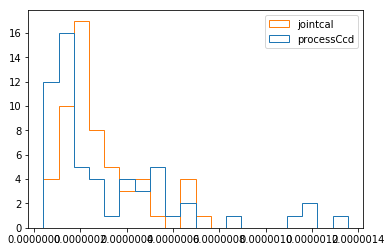

In [112]:
plt.hist((matchesp['distance'], matchesj['distance']), bins=20, histtype='step', label=['processCcd','jointcal'])
plt.legend()

In [88]:
matches1.matches[0].second.getCentroid()

Point2D(417.0126467, 4528.613211)

In [61]:
plt.imshow()

58

In [91]:
np.fromiter(((1,2), (3,4)), dtype=('float','float'))

ValueError: setting an array element with a sequence.